# Visual Optimization

In this first lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will start to familiarize ourselves with Python and use it to implement two gradient-based optimizer (steepest descent and conjugate gradient)  and gain some visual understanding when solving a linear systems of equations of the type:

$$\mathbf{d} = \mathbf{G} \mathbf{m}$$

where $\mathbf{G}$ is an $N \times N$ symmetric, positive definitive and real matrix. In this example we will use a toy N=2-dimensional problem.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scooby

In [2]:
def steepest_descent(G, d, niter=10, m0=None):
    """Steepest descent for minimizing ||d - Gm||^2 with square G
    """
    n = d.size
    if m0 is None:
        m = np.zeros_like(d)
    else:
        m = m0.copy()
    mh = np.zeros((niter + 1, n))
    mh[0] = m0.copy()
    
    r = d - np.dot(G, m)
    for i in range(niter):
        a = np.dot(r, r) / np.dot(r, np.dot(G, r))
        m = m + a*r
        mh[i + 1] = m.copy()
        r = d - np.dot(G, m)
        if np.linalg.norm(r) == 0:
            return mh[:i + 2]
    return mh
    
    
def conjgrad(G, d, niter=10, m0=None):
    """Conjugate-gradient for minimizing ||d - Gm||^2 with square G
    """
    n = d.size
    if m0 is None:
        m = np.zeros_like(d)
    else:
        m = m0.copy()
    mh = np.zeros((niter + 1, n))
    mh[0] = m0.copy()
    
    r = d - G.dot(m)
    d = r.copy()
    k = r.dot(r)
    for i in range(niter):
        Gd = G.dot(d)
        dGd = d.dot(Gd)
        a = k / dGd
        m = m + a*d
        mh[i + 1] = m.copy()
        r -= a*Gd
        kold = k
        k = r.dot(r)
        b = k / kold
        d = r + b*d
        if np.linalg.norm(r) == 0:
            return mh[:i + 2]
    return mh

Let's start by setting up the forward problem. 

We also compute the condition number of the operator $\mathbf{G}$ - note: the further the conditioning number from 1 the further the behaviour of the two solvers we will use in the following

In [3]:
offdiagG = 8. # element off-diagonal (increase to see how SD behaves)
m = np.array([0, 0])
G = np.array([[10., offdiagG], 
              [offdiagG, 10.]])

d = np.dot(G, m)
print('G eigenvalues', np.linalg.eig(G)[0])
print('G condition number %f' % np.linalg.cond(G))

G eigenvalues [18.  2.]
G condition number 9.000000


Let's define now the cost function to optimize:

$$ J = \frac{1}{2} \mathbf{m}^T \mathbf{G} \mathbf{m} - \mathbf{m}^T \mathbf{d} $$

In [4]:
# cost function grid
nm1, nm2 = 201, 201
m_min, m_max = (m[0] - 1.2, m[1] - 1.2), (m[0] + 1.2, m[1] + 1.2)
m1, m2 = np.mgrid[m_min[0]:m_max[0]:1j*nm1, m_min[1]:m_max[1]:1j*nm2]
mgrid = np.vstack((m1.ravel(), m2.ravel()))

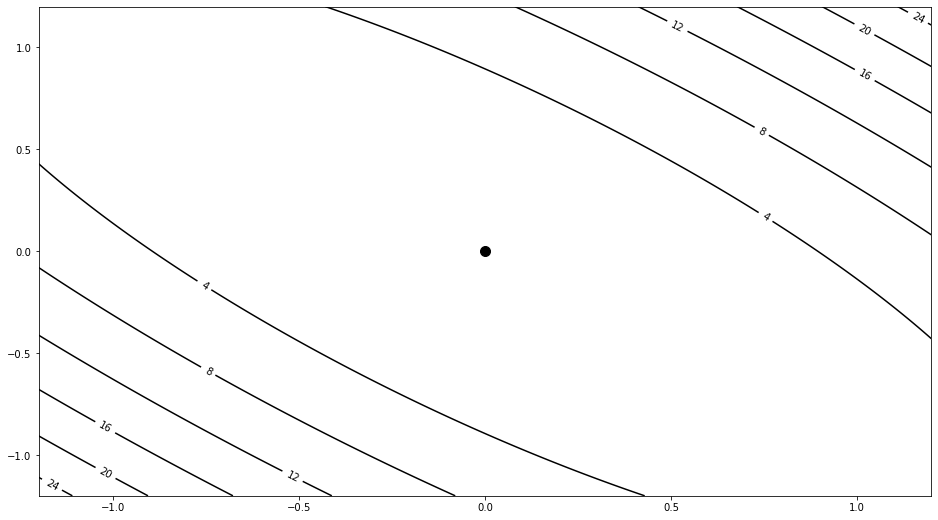

In [5]:
c = 0
J = 0.5 * np.sum(mgrid * np.dot(G, mgrid), axis=0) - np.dot(mgrid.T, d[:, np.newaxis]).squeeze() + c
J = J.reshape(nm1, nm2)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.contour(m1, m2, J, colors='k')
ax.clabel(cs, inline=1, fontsize=10);
ax.plot(m[0], m[1], '.k', ms=20)

At this point we compare the two solvers:
    
- Steepest descent:
    
    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} - \alpha_{k+1} \frac{dJ}{d\mathbf{m}_{k}} $$
    
    where $\mathbf{r} = \mathbf{d} - \mathbf{G}\mathbf{m}$, $\frac{dJ}{d\mathbf{m}} = -\mathbf{r}$, $\alpha = \frac{\mathbf{r}^T \mathbf{r}}{\mathbf{r}^T \mathbf{G} \mathbf{r}}$ (imposing that $\mathbf{r}_{k}$ and $\mathbf{r}_{k+1}$ are normal: $\mathbf{r}_{k+1}^T \mathbf{r}_{k} = 0$  ) .
    

- Conjugate gradient:
    
    $$\alpha = \frac{\mathbf{r}_{k}^T \mathbf{r}_{k}}{\mathbf{d}_{k}^T \mathbf{G} \mathbf{d}_{k}} $$
    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha \mathbf{d}_{k} $$
    $$\mathbf{r}_{k+1} = \mathbf{r}_{k} - \alpha \mathbf{G} \mathbf{d}_{k} $$
    $$\beta = \frac{\mathbf{r}_{k+1}^T \mathbf{r}_{k+1}}{\mathbf{r}_{k}^T \mathbf{r}_{k}}$$
    $$\mathbf{d}_{k+1} = \mathbf{r}_{k+1} + \beta \mathbf{d}_{k} $$
    
    where $\mathbf{d}_0 = \mathbf{r}_0 = \mathbf{d} - \mathbf{G}\mathbf{m}_0$.

Finally we display how the model changes through iterations for the two solvers

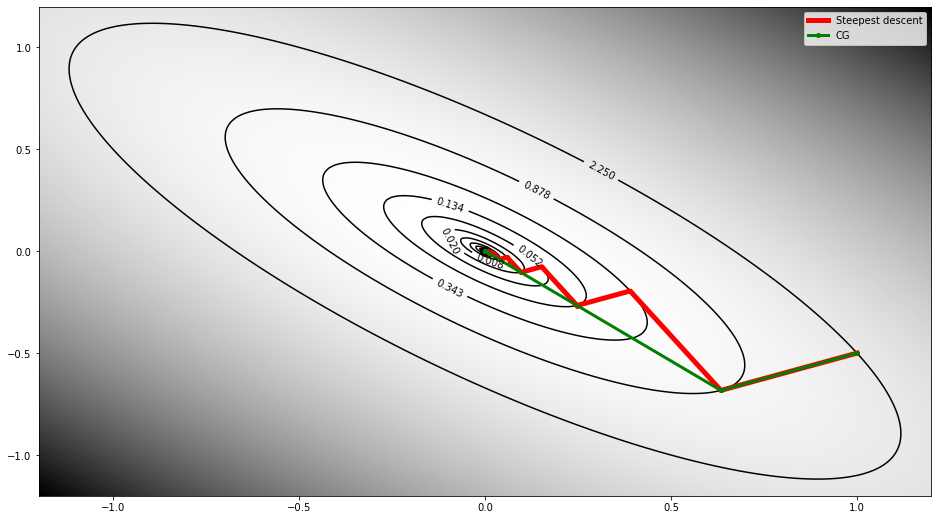

In [6]:
m0 = np.array([m[0]+1, m[1]-0.5])
msd = steepest_descent(G, d, niter=10, m0=m0)
mcg = conjgrad(G, d, niter=10, m0=m0)

# cost function at 
Jsd = 0.5 * np.sum(msd.T * np.dot(G, msd.T), axis=0) - np.dot(msd, d[:, np.newaxis]).squeeze() + c

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(Jsd), colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(msd[:, 0], msd[:, 1], '.-r', lw=5, ms=8, label='Steepest descent')
ax.plot(mcg[:, 0], mcg[:, 1], '.-g', lw=3, ms=8, label='CG')
ax.legend();
ax.axis('tight');

In [7]:
scooby.Report()

--------------------------------------------------------------------------------
  Date: Sat Jan 28 12:38:15 2023 +03

                OS : Darwin
            CPU(s) : 10
           Machine : x86_64
      Architecture : 64bit
               RAM : 16.0 GiB
       Environment : Jupyter
       File system : apfs

  Python 3.7.13 (default, Mar 28 2022, 07:24:34)  [Clang 12.0.0 ]

             numpy : 1.21.5
             scipy : 1.7.3
           IPython : 7.31.1
        matplotlib : 3.5.1
            scooby : 0.5.12

  Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------